In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras import utils as np_utils
from tqdm import tqdm
import re

In [2]:
train_df = pd.read_json('../../data/raw/raw_nyt/raw_train.json', lines = True)

In [3]:
print(train_df.columns)

Index(['sentText', 'articleId', 'relationMentions', 'entityMentions',
       'sentId'],
      dtype='object')


In [ ]:
train_df.head()

sentText  ... sentId
0  Massachusetts ASTON MAGNA Great Barrington ; a...  ...      1
1  North Carolina EASTERN MUSIC FESTIVAL Greensbo...  ...      2
2  It will be the final movie credited to Debra H...  ...      1
3  In a 3-0 victory over the Crew on Saturday in ...  ...      1
4  The United States ambassador to Mexico , Tony ...  ...      1

[5 rows x 5 columns]

In [4]:
#rel_sets -> relation_sets
relations = []
for rel_sets in train_df['relationMentions']:
  relations.append(rel_sets[0]['label'])
train_df['relations'] = relations

In [5]:
train_df['relations']

0                   /location/location/contains
1                   /location/location/contains
2                 /people/person/place_of_birth
3                   /location/location/contains
4                   /location/location/contains
                          ...                  
56191               /location/location/contains
56192                 /location/country/capital
56193                  /business/person/company
56194    /location/neighborhood/neighborhood_of
56195    /location/neighborhood/neighborhood_of
Name: relations, Length: 56196, dtype: object

<AxesSubplot:title={'center':'Relation Counts'}>

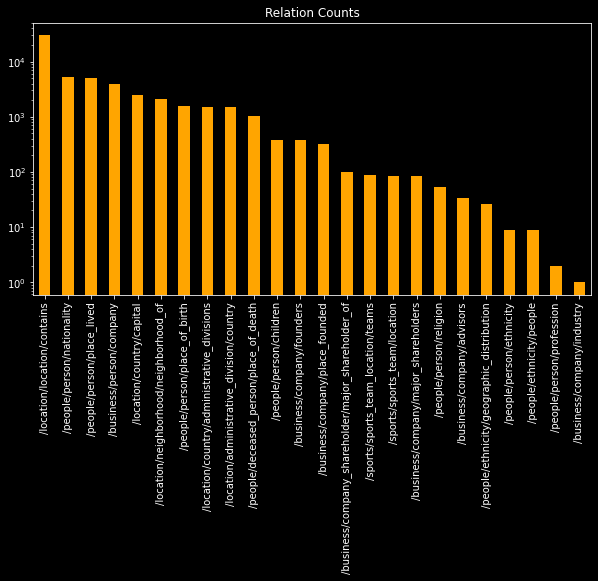

In [16]:
plt.style.use('dark_background')
train_df['relations'].value_counts().plot(kind='bar', title='Relation Counts', figsize=(10, 5), logy=True, color='orange')

In [ ]:
train_df['sentText'].head()

0    Massachusetts ASTON MAGNA Great Barrington ; a...
1    North Carolina EASTERN MUSIC FESTIVAL Greensbo...
2    It will be the final movie credited to Debra H...
3    In a 3-0 victory over the Crew on Saturday in ...
4    The United States ambassador to Mexico , Tony ...
Name: sentText, dtype: object

In [ ]:
X = []
for data in train_df['sentText']:
  X.append(data.lower())

In [ ]:
X[:10]

['massachusetts aston magna great barrington ; also at bard college , annandale-on-hudson , n.y. , july 1-aug .',
 'north carolina eastern music festival greensboro , june 25-july 30 .',
 "it will be the final movie credited to debra hill , a film producer and native of haddonfield , who produced '' halloween '' and was considered a pioneering woman in film .",
 "in a 3-0 victory over the crew on saturday in columbus , ohio , goalkeeper zach wells stopped kyle martino 's penalty kick , only the third unsuccessful penalty in 20 attempts in m.l.s. this season .",
 "the united states ambassador to mexico , tony garza , said in a statement that he had directed the american consulate in nuevo laredo to reopen on monday , a week after he ordered it closed because of '' rampant violence '' along the northern border , including a gun battle in the city in which warring drug gangs used bazookas .",
 'under pressure from mr. kerkorian and other disgruntled shareholders , mr. wagoner started talk

In [ ]:
def find_max_len(x, max_len):
  if(max_len < len(x.split())):
    max_len = len(x.split())
  return max_len

In [ ]:
max_len = 0
for x in train_df['sentText']:
  max_len = find_max_len(x, max_len)
print("Max Length = ", max_len)

Max Length =  100


In [ ]:
n_most_common_words = 65000 # vocabulary size
max_len = 100 # Max Length of Sequence
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;=?@[]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_df['sentText'].values)
sequences = tokenizer.texts_to_sequences(train_df['sentText'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
X = pad_sequences(sequences, maxlen=max_len) 

Found 64188 unique tokens.


In [ ]:
sequences

In [ ]:
print("Found", len(train_df.relations.unique()), "relations")

Found 24 relations


In [ ]:
dictionary = {}
rev_dictionary = {}
for i, rel in enumerate(train_df.relations.unique()):
  #map relation to index
  dictionary[rel] = i
  #map index to relation
  rev_dictionary[i] = rel

In [ ]:
print("Length of Relations = ", len(dictionary))
for key, values in dictionary.items():
  print(values, "  ----->   ", key)

Length of Relations =  24
0   ----->    /location/location/contains
1   ----->    /people/person/place_of_birth
2   ----->    /business/person/company
3   ----->    /people/person/place_lived
4   ----->    /location/administrative_division/country
5   ----->    /people/person/religion
6   ----->    /people/person/nationality
7   ----->    /people/person/children
8   ----->    /location/country/capital
9   ----->    /business/company/place_founded
10   ----->    /people/deceased_person/place_of_death
11   ----->    /location/country/administrative_divisions
12   ----->    /business/company/founders
13   ----->    /location/neighborhood/neighborhood_of
14   ----->    /business/company/advisors
15   ----->    /people/ethnicity/geographic_distribution
16   ----->    /sports/sports_team_location/teams
17   ----->    /sports/sports_team/location
18   ----->    /business/company_shareholder/major_shareholder_of
19   ----->    /business/company/major_shareholders
20   ----->    /people/person/

In [ ]:
encoded_relations = []
for rel in train_df['relations']:
  encoded_relations.append(dictionary[rel])
train_df['encoded_relations'] = encoded_relations

In [ ]:
train_df.head()

sentText  ... encoded_relations
0  Massachusetts ASTON MAGNA Great Barrington ; a...  ...                 0
1  North Carolina EASTERN MUSIC FESTIVAL Greensbo...  ...                 0
2  It will be the final movie credited to Debra H...  ...                 1
3  In a 3-0 victory over the Crew on Saturday in ...  ...                 0
4  The United States ambassador to Mexico , Tony ...  ...                 0

[5 rows x 7 columns]

In [ ]:
labels = np_utils.to_categorical(train_df['encoded_relations'], num_classes=len(train_df.encoded_relations.unique()))
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.20, random_state=42)

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
embedding_size = 300
model = Sequential()
model.add(Embedding(n_most_common_words, embedding_size, input_length=X.shape[1]))
model.add(Bidirectional(LSTM(128, dropout=0.7, recurrent_dropout=0.7)))
model.add(Dense(labels.shape[1], activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          19500000  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               439296    
_________________________________________________________________
dense (Dense)                (None, 24)                6168      
Total params: 19,945,464
Trainable params: 19,945,464
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
281/281 [==============================] - 274s 949ms/step - loss: 1.7825 - acc: 0.5450 - val_loss: 1.1063 - val_acc: 0.6848
Epoch 2/10
281/281 [==============================] - 270s 962ms/step - loss: 0.9786 - acc: 0.7112 - val_loss: 0.9150 - val_acc: 0.7022
Epoch 3/10
281/281 [==============================] - 270s 961ms/step - loss: 0.6838 - acc: 0.7688 - val_loss: 0.9431 - val_acc: 0.7083
Epoch 4/10
281/281 [==============================] - 270s 962ms/step - loss: 0.5115 - acc: 0.8251 - val_loss: 0.9472 - val_acc: 0.7083
Epoch 5/10
281/281 [==============================] - 269s 958ms/step - loss: 0.3875 - acc: 0.8653 - val_loss: 1.0588 - val_acc: 0.7135
Epoch 6/10
281/281 [==============================] - 269s 959ms/step - loss: 0.2975 - acc: 0.8950 - val_loss: 1.1809 - val_acc: 0.7129
Epoch 7/10
281/281 [==============================] - 272s 969ms/step - loss: 0.2458 - acc: 0.9128 - val_loss: 1.1953 - val_acc: 0.7021
Epoch 8/10
281/281 [============================

In [ ]:
prediction_probas = model.predict(X_test)
predictions = [np.argmax(pred) for pred in prediction_probas]
print(predictions[:10])

[10, 6, 11, 11, 0, 6, 0, 0, 13, 4]


In [ ]:
y_test_dup=np.argmax(y_test, axis=1)

In [ ]:
print(confusion_matrix(y_test_dup, predictions))

In [ ]:
print(classification_report(y_test_dup, predictions, digits=3))

              precision    recall  f1-score   support

           0      0.798     0.843     0.820      6042
           1      0.269     0.338     0.300       278
           2      0.855     0.726     0.785       851
           3      0.793     0.658     0.720      1013
           4      0.247     0.311     0.275       286
           5      0.000     0.000     0.000        12
           6      0.769     0.774     0.772      1030
           7      0.525     0.405     0.457        79
           8      0.430     0.304     0.356       483
           9      0.576     0.237     0.336        80
          10      0.449     0.271     0.338       210
          11      0.278     0.300     0.289       283
          12      0.357     0.495     0.415        91
          13      0.389     0.490     0.434       412
          14      1.000     0.429     0.600         7
          15      0.000     0.000     0.000         5
          16      0.250     0.188     0.214        16
          17      0.000    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Testing ------
seq = tokenizer.texts_to_sequences(['Steve Jobs Founded Apple'])

In [ ]:
test_sent = pad_sequences(seq, max_len)

In [ ]:
test_sent_pred = model.predict(test_sent)

In [ ]:
# Output -----
print(rev_dictionary[np.argmax(test_sent_pred)])

/business/person/company


In [ ]:
model.save('Prediction_model.h5')